In [2]:
# Import required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
import pandas as pd
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn.cluster import AgglomerativeClustering
import hdbscan

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read data file
data = pd.read_csv('mall.csv')
print(data.shape)
data.head()

(200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# Renaming columns
data.rename(columns={"Annual Income (k$)": "Annual_Income", "Spending Score (1-100)": "Spending_Score", "Genre" : "Gender"},inplace = True)
data.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data.drop('CustomerID',axis = 1,inplace = True)

In [6]:
# Check for data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          200 non-null    object
 1   Age             200 non-null    int64 
 2   Annual_Income   200 non-null    int64 
 3   Spending_Score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [7]:
data.isnull().sum()

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

In [8]:
data.describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [9]:
def myOutliers(df,col):
    Q3 = np.quantile(df[col],0.75)
    Q1 = np.quantile(df[col],0.25)
    
    IQR = Q3 - Q1
    
    global mylist
    global my_outlier_df
    
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    
    print('the lower range of',col,'is',lower_range)
    print('the upper range of',col,'is',upper_range)
    
    mylist = [x for x in df[col] if ((x < lower_range) | (x > upper_range))]
    print('total outliers in',col,'are',len(mylist))
    
    
    my_outlier_df = df.loc[df[col].isin(mylist)]
    return my_outlier_df

In [10]:
numeric_columns = ['Age','Annual_Income','Spending_Score']

for i in numeric_columns:
    myOutliers(data,i)
    print('**************************************')

the lower range of Age is -1.625
the upper range of Age is 79.375
total outliers in Age are 0
**************************************
the lower range of Annual_Income is -13.25
the upper range of Annual_Income is 132.75
total outliers in Annual_Income are 2
**************************************
the lower range of Spending_Score is -22.625
the upper range of Spending_Score is 130.375
total outliers in Spending_Score are 0
**************************************


In [11]:
data1 = data.copy()
bins= [11,21,31,41,51,61,71]
labels = ['11-20','21-30','31-40','41-50','51-60','61-70']
data1['AgeGroup'] = pd.cut(data1['Age'], bins=bins, labels=labels, right=False)
data1.head()

,Gender,Age,Annual_Income,Spending_Score,AgeGroup
0,Male,19,15,39,11-20
1,Male,21,15,81,21-30
2,Female,20,16,6,11-20
3,Female,23,16,77,21-30
4,Female,31,17,40,31-40


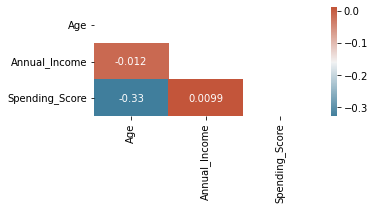

In [12]:
# Heatmap plot
corr = data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(5, 2))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,annot = True)
plt.show()

### Univariate Analysis

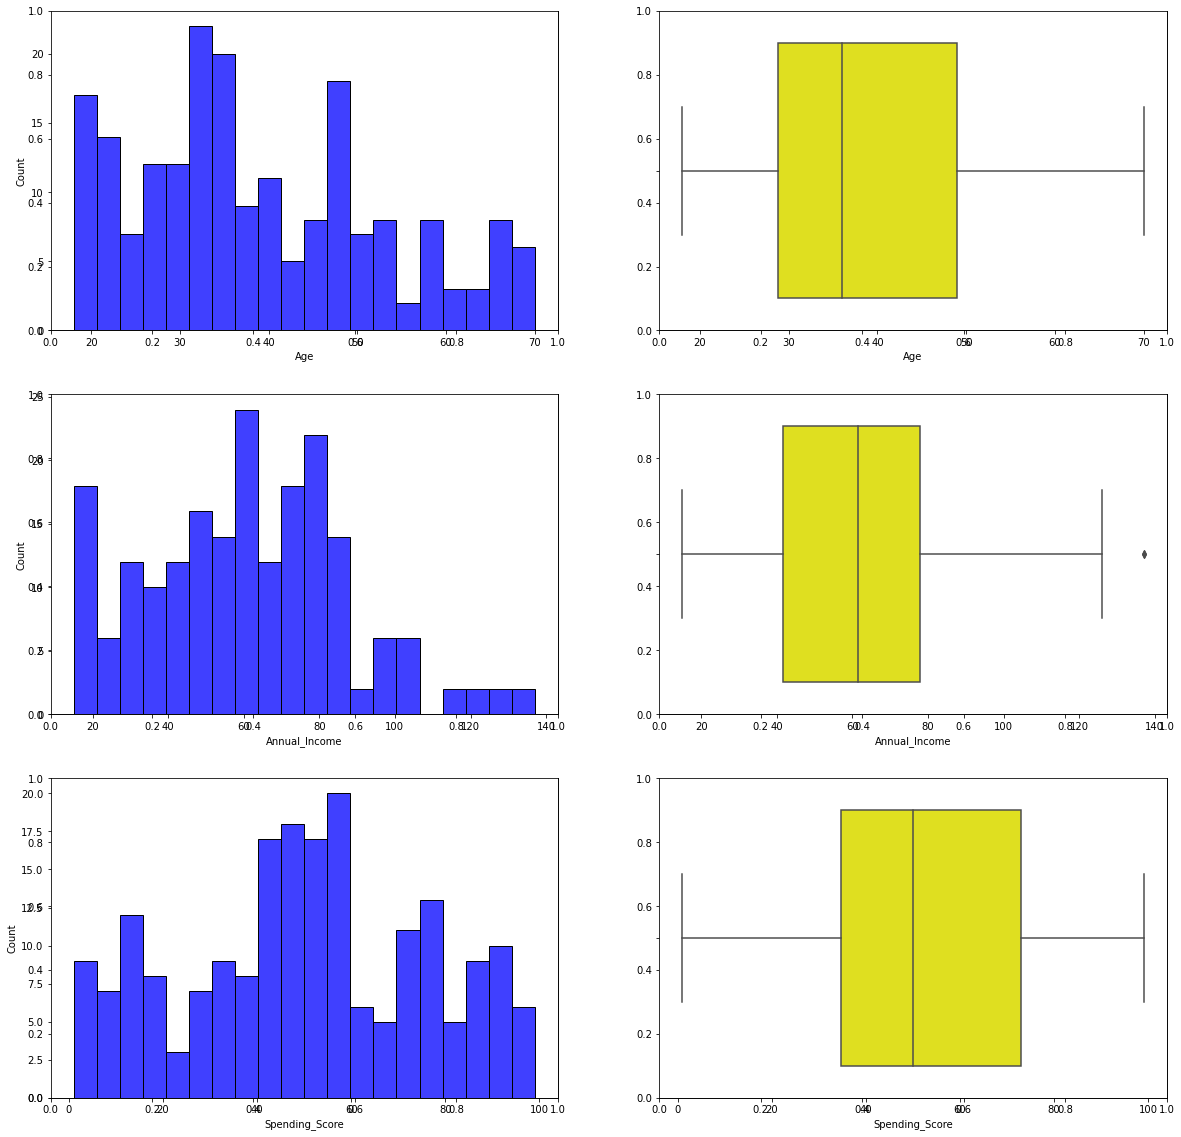

In [13]:
COLS = 2; POS = 1; ROWS = int(len(data.columns)-1)
fig,ax = plt.subplots(ROWS,COLS,figsize=(20,20))
for i in data.columns[1:]:
    fig.add_subplot(ROWS,COLS,POS)  
    sns.histplot(data[i],bins=20,color='blue')
    POS+= 1  
    fig.add_subplot(ROWS,COLS,POS)  
    sns.boxplot(data[i],color='yellow')
    POS+= 1

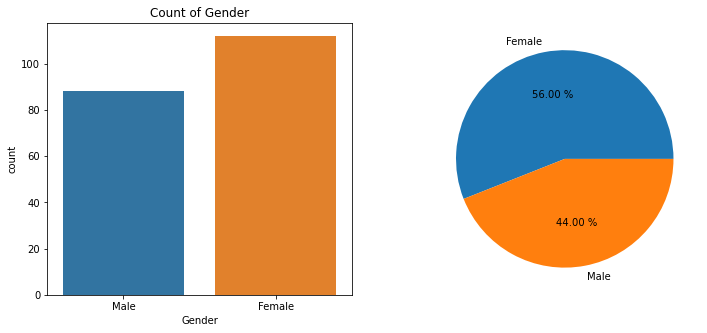

In [14]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].set_title('Count of Gender')
percentage = data['Gender'].value_counts()
labels = list(data['Gender'].value_counts().index)

sns.countplot(x = data['Gender'], ax = ax[0])
plt.pie(percentage,labels=labels,autopct = '%.2f %%')

plt.show()

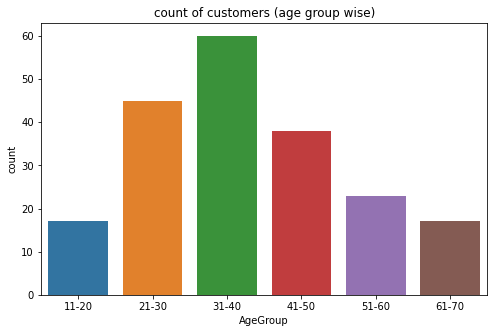

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x = data1['AgeGroup'])

plt.title('count of customers (age group wise)')
plt.show()

### Bi variate analysis

In [16]:
def annotate(bars,ax=ax):
    for bar in bars:
        height = bar.get_height()
        height = round(height,2)
        label_x_pos = bar.get_x() + bar.get_width() / 2
        ax.text(label_x_pos, height, s=f'{height}', ha='center',
        va='bottom')

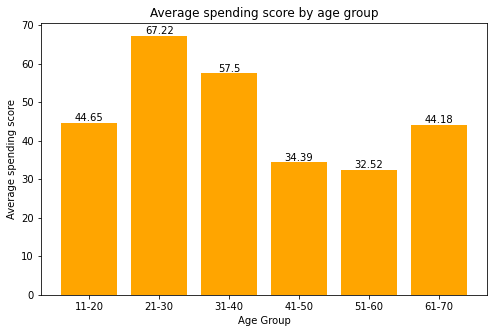

In [17]:
df = data1.groupby('AgeGroup')['Spending_Score'].mean()

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(df.index,df.values,color = 'orange')
annotate(bars,ax)
plt.xlabel('Age Group')
plt.ylabel('Average spending score')
plt.title('Average spending score by age group')
plt.show()

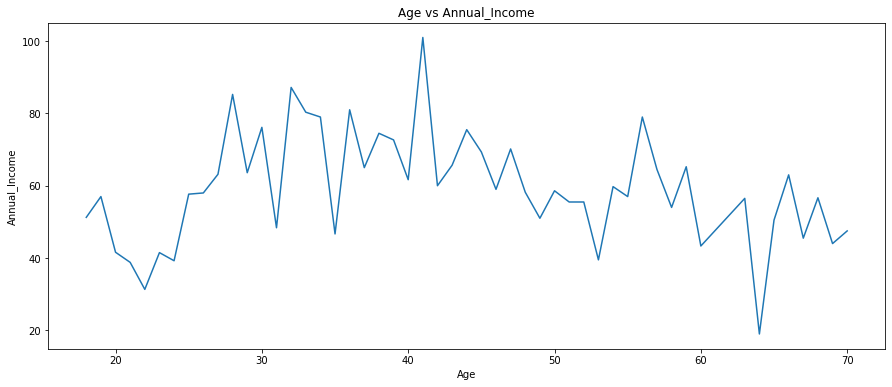

In [18]:
df = data.groupby('Age')['Annual_Income'].mean()

plt.figure(figsize=(15,6))
plt.plot(df.index,df.values)
plt.title('Age vs Annual_Income')
plt.xlabel('Age')
plt.ylabel('Annual_Income')
plt.show()

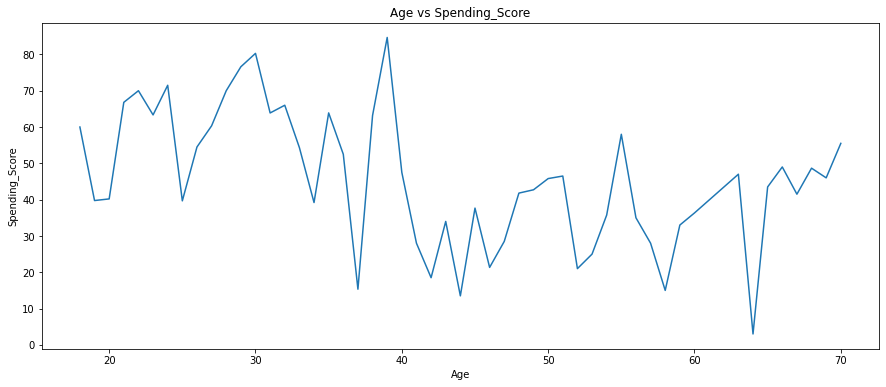

In [19]:
df = data.groupby('Age')['Spending_Score'].mean()


plt.figure(figsize=(15,6))
plt.plot(df.index,df.values)
plt.title('Age vs Spending_Score')
plt.xlabel('Age')
plt.ylabel('Spending_Score')
plt.show()

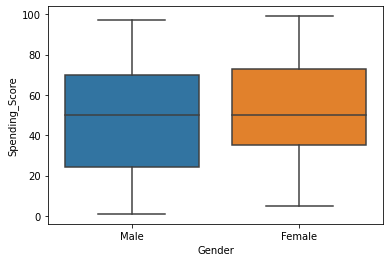

In [20]:
sns.boxplot('Gender','Spending_Score',data=data)

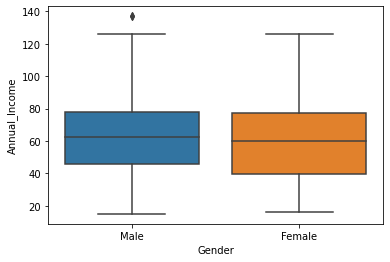

In [21]:
sns.boxplot('Gender','Annual_Income',data=data)

### Multi variate analysis

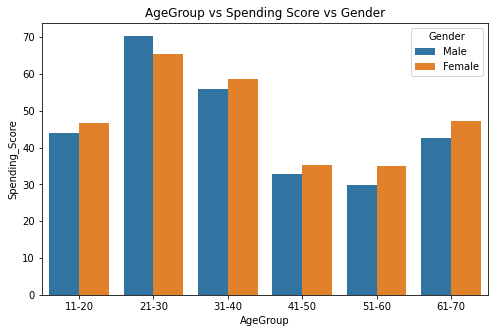

In [22]:
plt.figure(figsize = (8,5))
sns.barplot('AgeGroup','Spending_Score',hue = 'Gender',data = data1,ci=None)
plt.title('AgeGroup vs Spending Score vs Gender')
plt.show()

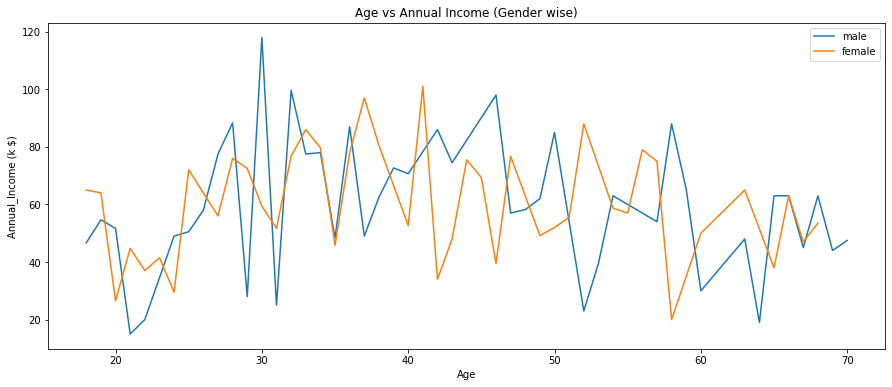

In [23]:
male = data[data['Gender']=='Male']
female = data[data['Gender']=='Female']

df_male = male.groupby('Age')['Annual_Income'].mean()
df_female = female.groupby('Age')['Annual_Income'].mean()

plt.figure(figsize=(15,6))
plt.plot(df_male.index,df_male.values,label = 'male')
plt.plot(df_female.index,df_female.values,label = 'female')
plt.legend(loc = 'upper')
plt.title('Age vs Annual Income (Gender wise)')
plt.xlabel('Age')
plt.ylabel('Annual_Income (k $)')
plt.show()

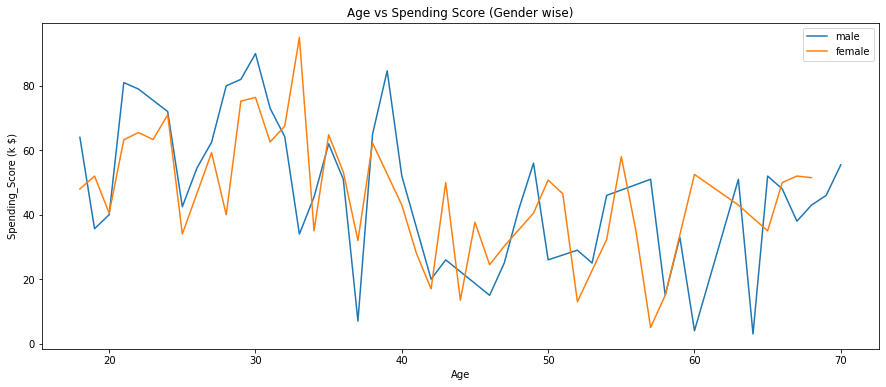

In [24]:
male = data[data['Gender']=='Male']
female = data[data['Gender']=='Female']

df_male = male.groupby('Age')['Spending_Score'].mean()
df_female = female.groupby('Age')['Spending_Score'].mean()

plt.figure(figsize=(15,6))
plt.plot(df_male.index,df_male.values,label = 'male')
plt.plot(df_female.index,df_female.values,label = 'female')
plt.legend(loc = 'upper')
plt.title('Age vs Spending Score (Gender wise)')
plt.xlabel('Age')
plt.ylabel('Spending_Score (k $)')
plt.show()

In [25]:
mm = MinMaxScaler()
data.iloc[:,1:] = mm.fit_transform(data.iloc[:,1:])

## Annual Income and Spending score

In [26]:
x1 = data.iloc[:, [2, 3]]

### K means

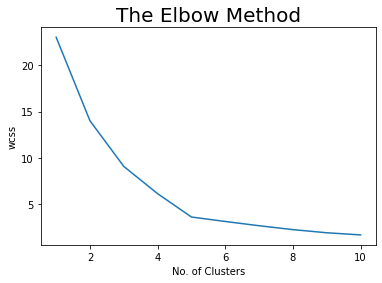

In [27]:
def plot_elbow(data):
    wcss = []
    for i in range(1, 11):
        km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        km.fit(data)
        wcss.append(km.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('The Elbow Method', fontsize = 20)
    plt.xlabel('No. of Clusters')
    plt.ylabel('wcss')
    plt.show()
    
plot_elbow(data = x1)

In [28]:
def get_silhouette_score_kmeans(data):
    for i in range(1, 11):
        try:
            km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            km.fit(data)
            silhouette_avg = silhouette_score(data, km.labels_)
            print('for n_clusters = ',i,", The average silhouette_score is :", silhouette_avg)
        except:
            continue
        
get_silhouette_score_kmeans(data = x1)

for n_clusters =  2 , The average silhouette_score is : 0.33340205479521
for n_clusters =  3 , The average silhouette_score is : 0.4514909309424474
for n_clusters =  4 , The average silhouette_score is : 0.49620078745146784
for n_clusters =  5 , The average silhouette_score is : 0.5594854531227246
for n_clusters =  6 , The average silhouette_score is : 0.5361045104756387
for n_clusters =  7 , The average silhouette_score is : 0.5239740654610379
for n_clusters =  8 , The average silhouette_score is : 0.42983975856498574
for n_clusters =  9 , The average silhouette_score is : 0.4430796733489202
for n_clusters =  10 , The average silhouette_score is : 0.44544917440590653


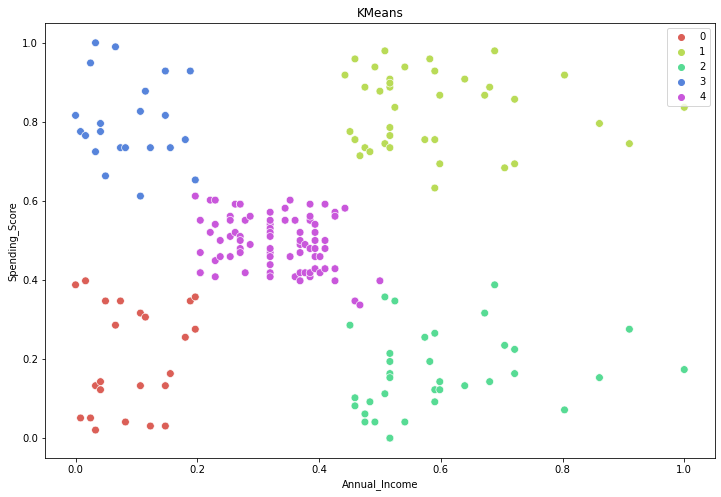

In [29]:
kmeans_scores = []

def plot_kmeans(n_clusters,data,ax = None,kmeans_scores = kmeans_scores):
    km = KMeans(n_clusters=n_clusters).fit(data)

    labels = km.labels_
    
    if ax == None:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=labels, 
                        palette=sns.color_palette('hls', np.unique(km.labels_).shape[0]),s= 60)
        plt.title('KMeans')
        plt.show()
    else:
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=labels, 
                        palette=sns.color_palette('hls', np.unique(km.labels_).shape[0]),s= 60 , ax = ax)
        ss = '  (silhouette_score = ' + str(round(silhouette_score(data, labels),4)) + ')'
        ax.set_title('KMeans' + ss)

        kmeans_scores.append(round(silhouette_score(data, labels),4))
    
plot_kmeans(n_clusters = 5,data = x1)

### DBSCAN

In [30]:
eps_range = [0.1,0.11,0.15,0.2]
min_samples_range = [6,7,8,9,10,11,12,13]

def get_silhouette_score_dbscan(eps_range,min_samples_range,data):
    for eps in eps_range:
        for min_samples in min_samples_range:
            try:
                db = DBSCAN(eps = eps, min_samples = min_samples).fit(data)
                silhouette_avg = silhouette_score(data, db.labels_)
                print('for eps = ',eps,',min_samples = ',min_samples,", The average silhouette_score is :", silhouette_avg)
            except:
                continue
                
get_silhouette_score_dbscan(eps_range,min_samples_range,data = x1)

for eps =  0.1 ,min_samples =  6 , The average silhouette_score is : 0.3086117186144806
for eps =  0.1 ,min_samples =  7 , The average silhouette_score is : 0.42235418201628017
for eps =  0.1 ,min_samples =  8 , The average silhouette_score is : 0.4243487685822454
for eps =  0.1 ,min_samples =  9 , The average silhouette_score is : 0.3723950760687758
for eps =  0.1 ,min_samples =  10 , The average silhouette_score is : 0.3559823539070333
for eps =  0.1 ,min_samples =  11 , The average silhouette_score is : 0.34527335596938885
for eps =  0.1 ,min_samples =  12 , The average silhouette_score is : 0.3123152638224785
for eps =  0.1 ,min_samples =  13 , The average silhouette_score is : 0.22294009726717795
for eps =  0.11 ,min_samples =  6 , The average silhouette_score is : 0.3142024935728663
for eps =  0.11 ,min_samples =  7 , The average silhouette_score is : 0.3142024935728663
for eps =  0.11 ,min_samples =  8 , The average silhouette_score is : 0.41016511962620344
for eps =  0.11 ,min_

Best silhouette score is obtained for eps = 0.1, min_samples = 8

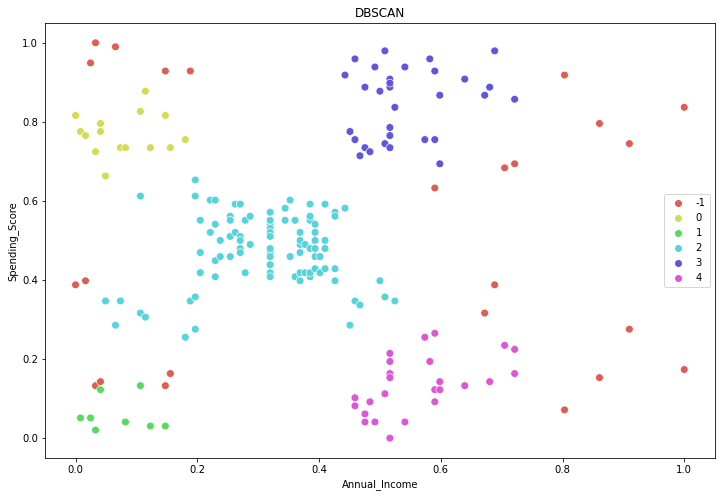

In [31]:
dbscan_scores = []


def plot_dbscan(eps,min_samples,data,ax = None, dbscan_scores = dbscan_scores):
    db = DBSCAN(eps=eps,min_samples=min_samples).fit(data)
    
    if ax == None:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=db.labels_, 
                        palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]),s= 60)
        plt.title('DBSCAN')
        plt.show()
    else:
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=db.labels_, 
                        palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]),s= 60 , ax = ax)
        ss = '  (silhouette_score = ' + str(round(silhouette_score(data, db.labels_),4)) + ')'
        ax.set_title('DBSCAN' + ss)
        
        dbscan_scores.append(round(silhouette_score(data, db.labels_),4))

plot_dbscan(eps = 0.1,min_samples = 8, data = x1)

### HDBSCAN

In [32]:
min_cluster_size_range = [2,3,4,5,6,7,8,9,10,11,12,13]

def get_silhouette_score_hdbscan(min_cluster_size_range,data,plt = plt):
    for min_cluster_size in min_cluster_size_range:
        try:
            hdbscan_clus = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
            hdbscan_clus.fit(data)
            silhouette_avg = silhouette_score(data, hdbscan_clus.labels_)
            print('for min_cluster_size = ',min_cluster_size," The average silhouette_score is :", silhouette_avg)
        except:
            continue

get_silhouette_score_hdbscan(min_cluster_size_range,x1)

for min_cluster_size =  2  The average silhouette_score is : 0.23692754341792768
for min_cluster_size =  3  The average silhouette_score is : 0.30619145449913066
for min_cluster_size =  4  The average silhouette_score is : 0.41829849623790616
for min_cluster_size =  5  The average silhouette_score is : 0.39189520502974856
for min_cluster_size =  6  The average silhouette_score is : 0.37463039236013274
for min_cluster_size =  7  The average silhouette_score is : 0.37240717682175495
for min_cluster_size =  8  The average silhouette_score is : 0.3316969052571887
for min_cluster_size =  9  The average silhouette_score is : 0.3306780612122374
for min_cluster_size =  10  The average silhouette_score is : 0.29135738508984044
for min_cluster_size =  11  The average silhouette_score is : 0.26770504969770237
for min_cluster_size =  12  The average silhouette_score is : 0.23904631012716712
for min_cluster_size =  13  The average silhouette_score is : 0.22118206947540023


Best silhouette score is obtained for min_cluster_size = 4

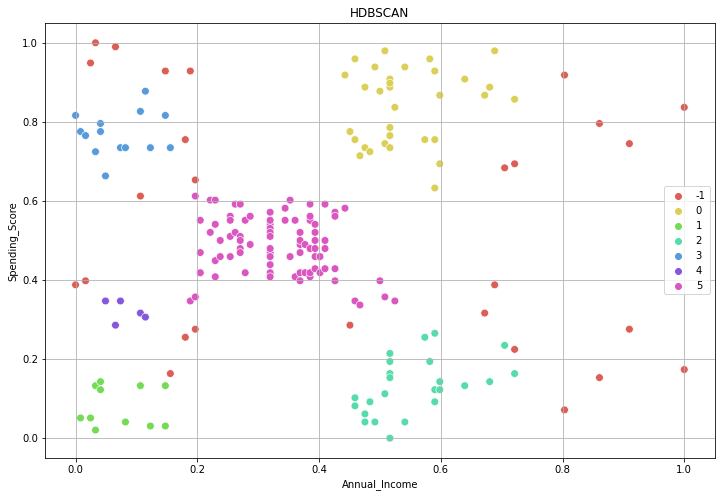

In [33]:
hdbscan_scores = []

def plot_hdbscan(min_cluster_size,data, ax = None, hdbscan_scores = hdbscan_scores):
    hdbscan_clus = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
    hdbscan_clus.fit(data)
    
    if ax == None:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=hdbscan_clus.labels_, 
        palette=sns.color_palette('hls', np.unique(hdbscan_clus.labels_).shape[0]),s= 60)
        plt.title('HDBSCAN')
        plt.grid()
        plt.show()
    else:
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=hdbscan_clus.labels_, 
        palette=sns.color_palette('hls', np.unique(hdbscan_clus.labels_).shape[0]),s= 60, ax = ax)
        ss = '  (silhouette_score = ' + str(round(silhouette_score(data, hdbscan_clus.labels_),4)) + ')'
        ax.set_title('HDBSCAN' + ss)
        
        hdbscan_scores.append(round(silhouette_score(data, hdbscan_clus.labels_),4))
    
plot_hdbscan(min_cluster_size = 4,data = x1)

### AgglomerativeClustering

In [34]:
x1

,Annual_Income,Spending_Score
0,0.000000,0.387755
1,0.000000,0.816327
2,0.008197,0.051020
3,0.008197,0.775510
4,0.016393,0.397959
...,...,...
195,0.860656,0.795918
196,0.909836,0.275510
197,0.909836,0.744898
198,1.000000,0.173469


In [35]:
range_n_clusters = [2,3,4,5,6,7]
linkages = ['average','ward','complete','single']

def get_silhouette_score_agglomerative(range_n_clusters,linkages,data):
    for n_clusters in range_n_clusters:
        for linkage in linkages:
            agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(data)
            silhouette_avg = silhouette_score(data, agglom.labels_)
            print('for n_clusters = ',n_clusters,',linkage = ',linkage,", The average silhouette_score is :", silhouette_avg)
        print('*'*100)

get_silhouette_score_agglomerative(range_n_clusters,linkages,data = x1)

for n_clusters =  2 ,linkage =  average , The average silhouette_score is : 0.39090074716611595
for n_clusters =  2 ,linkage =  ward , The average silhouette_score is : 0.39090074716611595
for n_clusters =  2 ,linkage =  complete , The average silhouette_score is : 0.33496824180287277
for n_clusters =  2 ,linkage =  single , The average silhouette_score is : 0.4012206646865636
****************************************************************************************************
for n_clusters =  3 ,linkage =  average , The average silhouette_score is : 0.4503797002600712
for n_clusters =  3 ,linkage =  ward , The average silhouette_score is : 0.44796167261691394
for n_clusters =  3 ,linkage =  complete , The average silhouette_score is : 0.4503797002600712
for n_clusters =  3 ,linkage =  single , The average silhouette_score is : 0.28350094695389094
****************************************************************************************************
for n_clusters =  4 ,linkage =  average

Best silhouette score is obtained for n_clusters = 5, linkage = 'ward'

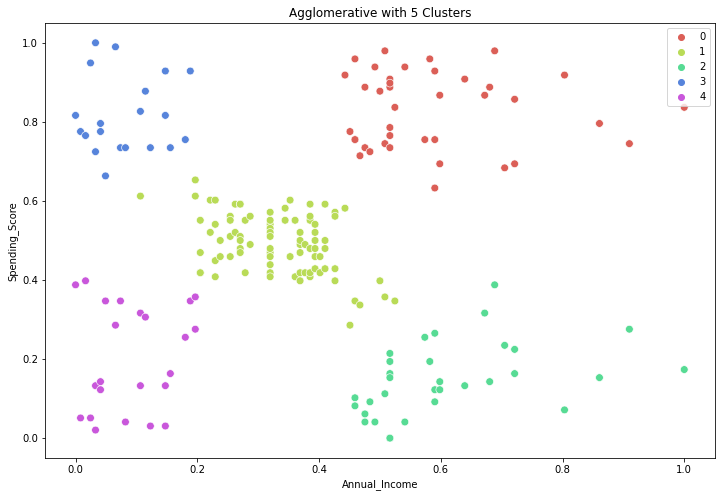

In [36]:
agglom_scores = []


def plot_agglomerative(n_clusters,linkage,data,ax = None,agglom_scores = agglom_scores):
    agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage = linkage).fit(data)
    
    if ax == None:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=agglom.labels_, 
                        palette=sns.color_palette('hls', np.unique(agglom.labels_).shape[0]),s = 60)
        plt.title('Agglomerative with ' + str(n_clusters) +' Clusters')
        plt.show()
    else:
        sns.scatterplot(x = data[data.columns[0]],y = data[data.columns[1]], hue=agglom.labels_, 
                        palette=sns.color_palette('hls', np.unique(agglom.labels_).shape[0]), ax = ax,s = 60)
        ss = '  (silhouette_score = ' + str(round(silhouette_score(data, agglom.labels_),4)) + ')'
        ax.set_title('Agglomerative' + ss)
        
        agglom_scores.append(round(silhouette_score(data, agglom.labels_),4))
        
plot_agglomerative(n_clusters = 5,linkage = 'ward',data=x1)

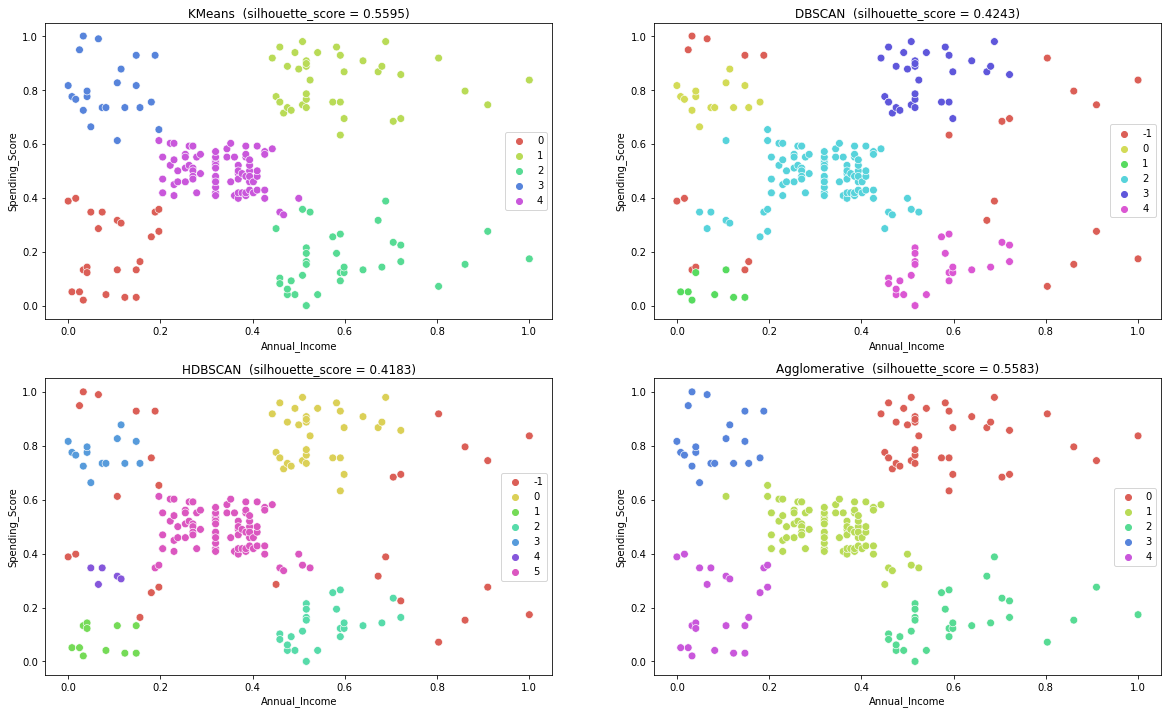

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
plot_kmeans(n_clusters = 5,data = x1,ax = ax[0][0])
plot_dbscan(eps = 0.1,min_samples = 8, data = x1,ax = ax[0][1])
plot_hdbscan(min_cluster_size = 4,data = x1,ax = ax[1][0])
plot_agglomerative(n_clusters = 5,linkage = 'ward',data=x1,ax = ax[1][1])

## Age and Spending Score

In [38]:
x2 = data.iloc[:, [1, 3]]

### Kmeans

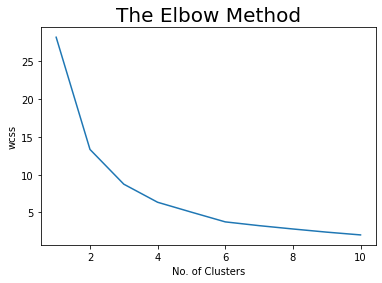

for n_clusters =  2 , The average silhouette_score is : 0.47252865228696783
for n_clusters =  3 , The average silhouette_score is : 0.44058221683010546
for n_clusters =  4 , The average silhouette_score is : 0.4359241957977821
for n_clusters =  5 , The average silhouette_score is : 0.44130347199309145
for n_clusters =  6 , The average silhouette_score is : 0.4554676382159921
for n_clusters =  7 , The average silhouette_score is : 0.4047424092072742
for n_clusters =  8 , The average silhouette_score is : 0.4046902013558962
for n_clusters =  9 , The average silhouette_score is : 0.40926679128272225
for n_clusters =  10 , The average silhouette_score is : 0.44154239670967044


In [39]:
plot_elbow(data = x2)
get_silhouette_score_kmeans(data = x2)

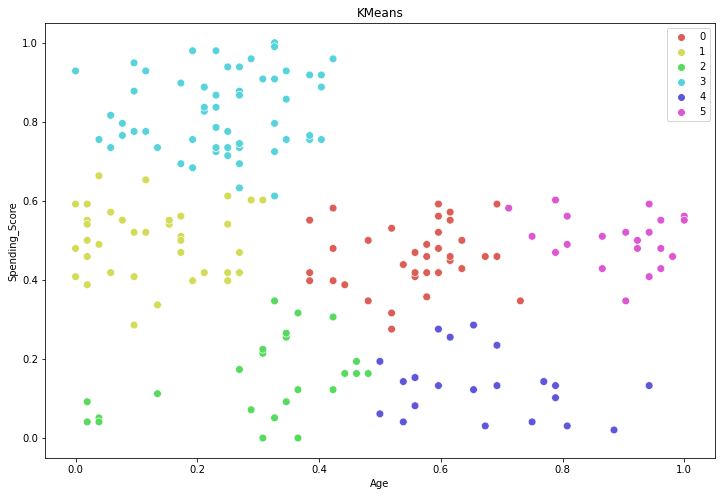

In [40]:
plot_kmeans(n_clusters = 6, data = x2)

### DBSCAN

In [41]:
eps_range = [0.1, 0.11, 0.12,0.13,0.15,0.2]
get_silhouette_score_dbscan(eps_range, min_samples_range, data = x2)

for eps =  0.1 ,min_samples =  6 , The average silhouette_score is : 0.21187032500973363
for eps =  0.1 ,min_samples =  7 , The average silhouette_score is : 0.23454815881543317
for eps =  0.1 ,min_samples =  8 , The average silhouette_score is : 0.23779217290503118
for eps =  0.1 ,min_samples =  9 , The average silhouette_score is : 0.3513294589406254
for eps =  0.1 ,min_samples =  10 , The average silhouette_score is : 0.29788894450578485
for eps =  0.1 ,min_samples =  11 , The average silhouette_score is : 0.27248353455986135
for eps =  0.1 ,min_samples =  12 , The average silhouette_score is : 0.2858199295617393
for eps =  0.1 ,min_samples =  13 , The average silhouette_score is : 0.2858199295617393
for eps =  0.11 ,min_samples =  6 , The average silhouette_score is : 0.2570042408540958
for eps =  0.11 ,min_samples =  7 , The average silhouette_score is : 0.2570042408540958
for eps =  0.11 ,min_samples =  8 , The average silhouette_score is : 0.2319850735620068
for eps =  0.11 ,min

Best silhouette score is obtained for eps = 0.12, min_samples = 12

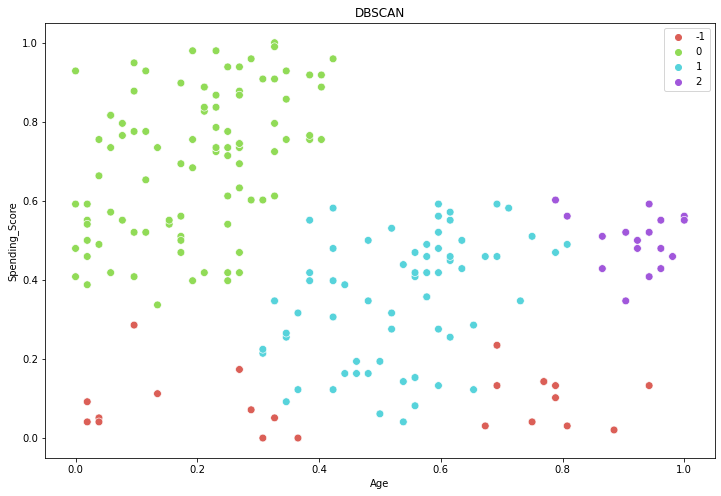

In [42]:
plot_dbscan(eps = 0.12, min_samples = 12, data = x2)

### HDBSCAN

In [43]:
min_cluster_size_range = range(2,30)
get_silhouette_score_hdbscan(min_cluster_size_range, data = x2)

for min_cluster_size =  2  The average silhouette_score is : 0.17666540239509365
for min_cluster_size =  3  The average silhouette_score is : 0.1935333807085391
for min_cluster_size =  4  The average silhouette_score is : 0.0838573586381881
for min_cluster_size =  5  The average silhouette_score is : 0.16550142463703238
for min_cluster_size =  6  The average silhouette_score is : 0.04816867465934355
for min_cluster_size =  7  The average silhouette_score is : 0.006189077822445961
for min_cluster_size =  8  The average silhouette_score is : 0.0994245295856553
for min_cluster_size =  9  The average silhouette_score is : 0.08474867760748392
for min_cluster_size =  10  The average silhouette_score is : 0.017256985800363535
for min_cluster_size =  11  The average silhouette_score is : 0.008810831736652949
for min_cluster_size =  12  The average silhouette_score is : 0.09264678173516455
for min_cluster_size =  13  The average silhouette_score is : 0.0912799579754613
for min_cluster_size =  1

Best silhouette score is obtained for min_cluster_size = 23

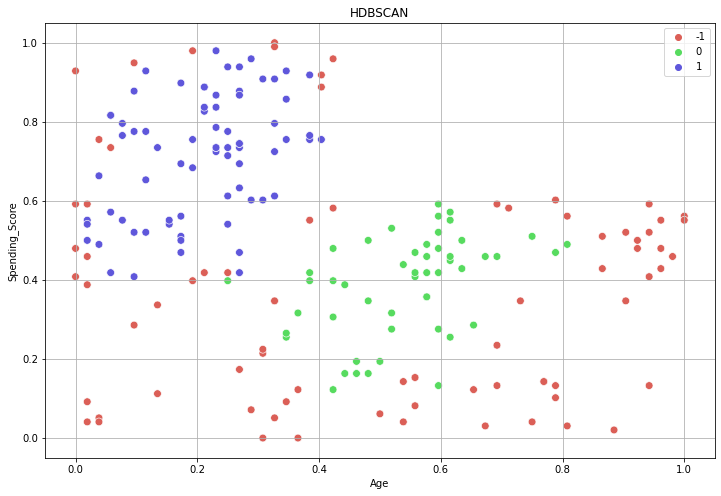

In [44]:
plot_hdbscan(min_cluster_size = 23, data = x2)

### Agglomerative

In [45]:
get_silhouette_score_agglomerative(range_n_clusters, linkages, data = x2)

for n_clusters =  2 ,linkage =  average , The average silhouette_score is : 0.2504360095297992
for n_clusters =  2 ,linkage =  ward , The average silhouette_score is : 0.41699937625242867
for n_clusters =  2 ,linkage =  complete , The average silhouette_score is : 0.4074885608283321
for n_clusters =  2 ,linkage =  single , The average silhouette_score is : 0.2504360095297992
****************************************************************************************************
for n_clusters =  3 ,linkage =  average , The average silhouette_score is : 0.4200820416058732
for n_clusters =  3 ,linkage =  ward , The average silhouette_score is : 0.417124576652748
for n_clusters =  3 ,linkage =  complete , The average silhouette_score is : 0.40841629074726027
for n_clusters =  3 ,linkage =  single , The average silhouette_score is : 0.0838573586381881
****************************************************************************************************
for n_clusters =  4 ,linkage =  average , T

Best silhouette score is obtained for n_clusters = 7, linkage = 'average'

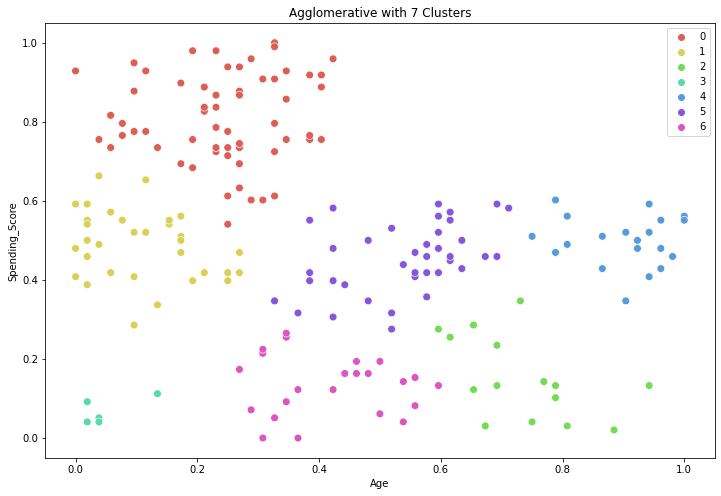

In [46]:
plot_agglomerative(n_clusters = 7, linkage = 'average', data = x2)

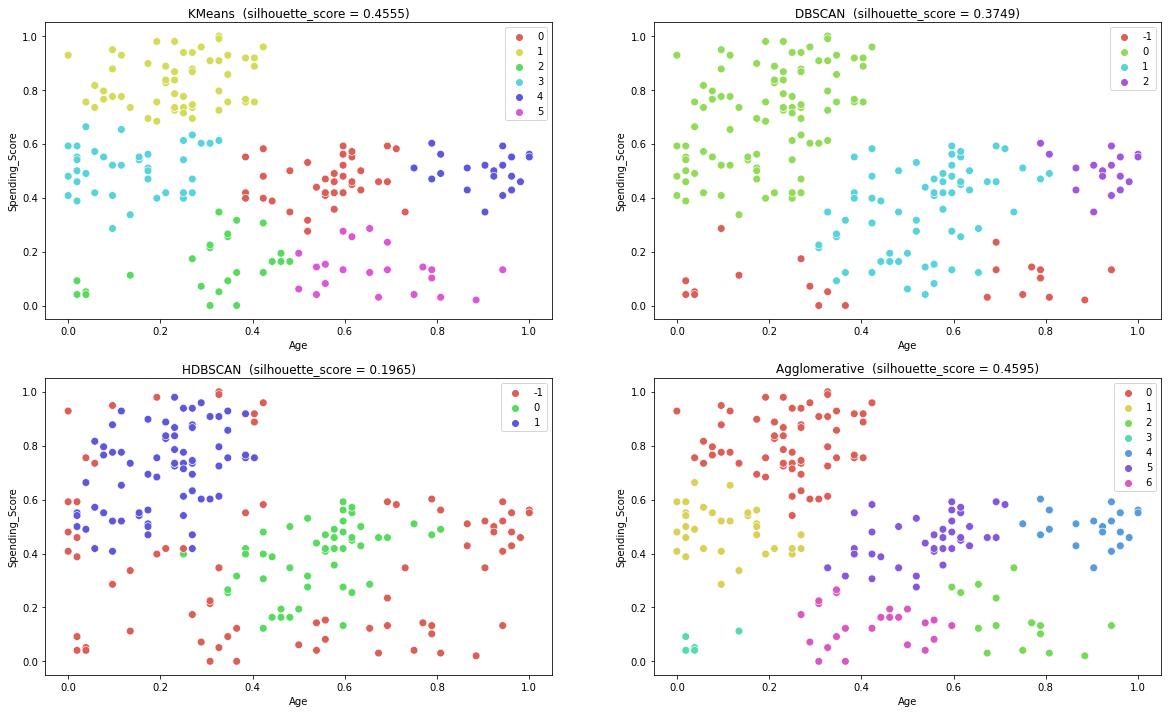

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
plot_kmeans(n_clusters = 6, data = x2, ax = ax[0][0])
plot_dbscan(eps = 0.12, min_samples = 12, data = x2, ax = ax[0][1])
plot_hdbscan(min_cluster_size = 23, data = x2, ax = ax[1][0])
plot_agglomerative(n_clusters = 7, linkage = 'average', data = x2, ax = ax[1][1])

In [50]:
features = ['Annual Income and Spending Score', 'Age and Spending Score']

df = pd.DataFrame({
    'Features' : features,
    'KMeans' : kmeans_scores,
    'DBSCAN' : dbscan_scores,
    'HDBSCAN' : hdbscan_scores,
    'Agglomerative' : agglom_scores
})
df

,Features,KMeans,DBSCAN,HDBSCAN,Agglomerative
0,Annual Income and Spending Score,0.5595,0.4243,0.4183,0.5583
1,Age and Spending Score,0.4555,0.3749,0.1965,0.4595


Based on the silhouette score i have chosen the best clustering algorithm as KMeans for the features Annual Income and Spending score.

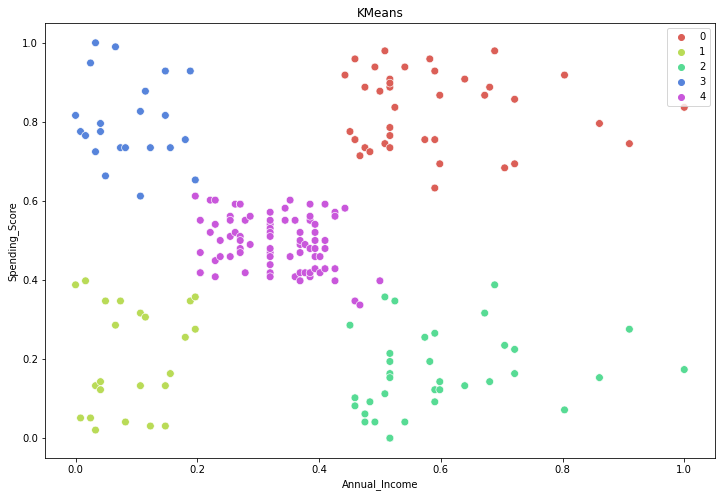

In [48]:
plot_kmeans(n_clusters = 5,data = x1)

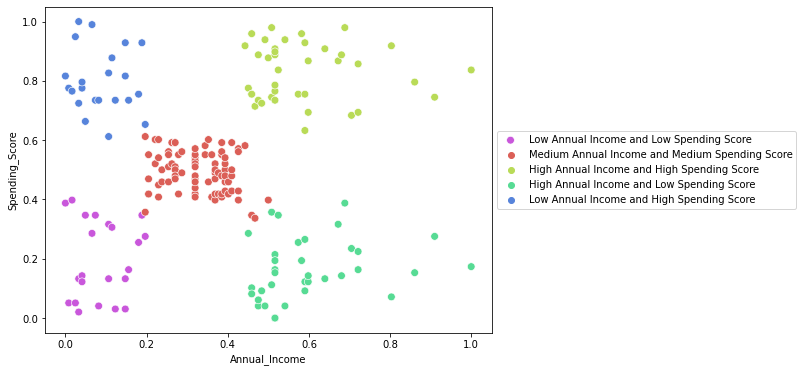

In [83]:
x = np.arange(10)

fig = plt.figure(figsize = (10,6))
ax = plt.subplot(111)

km = KMeans(n_clusters=5).fit(x1)

labels = km.labels_

sns.scatterplot(x = x1[x1.columns[0]],y = x1[x1.columns[1]], hue=labels, 
                palette=sns.color_palette('hls', np.unique(km.labels_).shape[0]),s= 60)

# ax.legend
# ax.legend(, title = "Legend")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Low Annual Income and Low Spending Score',
           'Medium Annual Income and Medium Spending Score',
           'High Annual Income and High Spending Score',
           'High Annual Income and Low Spending Score',
           'Low Annual Income and High Spending Score'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()